# Checking consistency between Night and Day samples and merging them

This notebook is for checking consistency between day and night samples for the metataxonomic samples (Wallace et al. 2018) after running the cutadapt and dada2 pipeline only for the forward reads. I (RACS) will also to the same verification for the OTUs table from Wallace et al (2018).

Differently from the RNA-seq data, we do not expect the metataxonomic data to change significantly between day and night samples of the same day.

Using the feature table with ASVs generated with dada2 using the reads with minimum of 20 quality score, on side of fragments (Forward)!

### Analysis with the ASVs table

In [72]:
import pandas as pd

In [107]:
kremling_expression_key = '/home/rsantos/Repositories/maize_microbiome_transcriptomics/correlations_rnaseq_metataxonomics/0_kremling_expression_key.txt'
sra_run_table_16s = '/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/SraRunInfo_Wallace_etal_2018.csv'

In [108]:
kremling_expression_key_dict = {}

with open(kremling_expression_key, 'r') as file:

    _ = file.readline()

    for line in file:
        fields = line.strip().split('\t')
        
        kremling_identifier = fields[0]
        wallace_identifier = fields[1]

        kremling_expression_key_dict[wallace_identifier] = kremling_identifier

In [109]:
wallace_asvs = pd.read_csv('/media/rsantos/4TB_drive/Projects/UGA_RACS/16S/Qiime2/dada2/as_single_q20/table-paired-end_wallace2018_assingle_forward_q20-dada2_feature-table/q20_fw_feature-table.tsv',
                           sep='\t')

# Rename column and reset the index
wallace_asvs.rename(columns={'ASV': 'Name'}, inplace=True)
wallace_asvs.set_index('Name', inplace=True)

# Print the dataframe
wallace_asvs.shape

(6241, 592)

In [110]:
genotype_day_day_dict = {}
genotype_day_night_dict = {}

with open(sra_run_table_16s, 'r') as file:

    _ = file.readline()

    for line in file:
        day_genotype_in_dict = False
        fields = line.strip().split(',')
        fields2 = fields[11].split('.')
        metataxonomics_run_id = fields[0]
        day = int(fields2[1])
        day_period = fields2[0]
        day_period = day_period.replace('LMA', '')
        if fields[11] in kremling_expression_key_dict.keys():
            plot = fields[11].split('.')[2]
            genotype = kremling_expression_key_dict[fields[11]].split('_')[2]
            if day_period == 'D':
                genotype_day_day_dict[metataxonomics_run_id] = str(day)+"_"+genotype+"_"+plot
                print('Added to day dict: ', metataxonomics_run_id, genotype_day_day_dict[metataxonomics_run_id], day_period, day)
            if day_period == 'N':
                genotype_day_night_dict[metataxonomics_run_id] = str(day)+"_"+genotype+"_"+plot
                print('Added to night dict: ', metataxonomics_run_id, genotype_day_night_dict[metataxonomics_run_id], day_period, day)

Added to night dict:  SRR6665477 26_B73_14A0113 N 26
Added to night dict:  SRR6665478 26_NC262_14A0093 N 26
Added to night dict:  SRR6665479 26_CML10_14A0169 N 26
Added to night dict:  SRR6665480 26_NC314_14A0167 N 26
Added to night dict:  SRR6665481 26_B46_14A0157 N 26
Added to night dict:  SRR6665482 26_B84_14A0155 N 26
Added to night dict:  SRR6665483 26_B73_14A0185 N 26
Added to night dict:  SRR6665484 26_B77_14A0171 N 26
Added to night dict:  SRR6665485 8_F7_14A0009 N 8
Added to night dict:  SRR6665486 8_ND246_14A0011 N 8
Added to night dict:  SRR6665487 8_A654_14A0013 N 8
Added to night dict:  SRR6665488 8_CO106_14A0015 N 8
Added to night dict:  SRR6665490 8_EP1_14A0019 N 8
Added to night dict:  SRR6665491 8_A188_14A0021 N 8
Added to night dict:  SRR6665492 8_A659_14A0023 N 8
Added to night dict:  SRR6665493 8_CMV3_14A0025 N 8
Added to night dict:  SRR6665494 8_CO125_14A0027 N 8
Added to night dict:  SRR6665495 8_NC260_14A0187 N 8
Added to night dict:  SRR6665497 8_NC310_14A0201 

In [111]:
print(len(genotype_day_day_dict))
print(len(genotype_day_night_dict))

210
272


In [112]:
wallace_asvs_day_cols = wallace_asvs.loc[:, list(genotype_day_day_dict.keys())]
wallace_asvs_night_cols = wallace_asvs.loc[:, list(genotype_day_night_dict.keys())]

print(wallace_asvs_day_cols.shape)
print(wallace_asvs_night_cols.shape)

(6241, 210)
(6241, 272)


#### Renaming the columns from runs to "day_genotype_plot"

In [113]:
wallace_asvs_day_cols = wallace_asvs_day_cols.rename(columns=genotype_day_day_dict)
wallace_asvs_night_cols = wallace_asvs_night_cols.rename(columns=genotype_day_night_dict)

In [114]:
wallace_asvs_day_cols.shape

(6241, 210)

In [115]:
wallace_asvs_night_cols.shape

(6241, 272)

#### Filter columns that are present in day and night period matrices based on "day_genotype_plot" association

In [116]:
wallace_asvs_night_cols_filtered = wallace_asvs_night_cols.filter(items=wallace_asvs_day_cols.columns)

In [117]:
wallace_asvs_day_cols_filtered = wallace_asvs_day_cols.filter(items=wallace_asvs_night_cols.columns)

In [118]:
print(wallace_asvs_day_cols.shape)
print(wallace_asvs_night_cols.shape)
print(wallace_asvs_night_cols_filtered.shape)
print(wallace_asvs_day_cols_filtered.shape)

(6241, 210)
(6241, 272)
(6241, 207)
(6241, 207)


In [119]:
if wallace_asvs_night_cols_filtered.columns.all() == wallace_asvs_day_cols_filtered.columns.all():
    print('Columns are equal!')

In [120]:
wallace_asvs_night_cols_filtered.head()

,26_CML10_14A0169,26_B77_14A0171,26_B46_14A0157,26_NC314_14A0167,26_B52_14A0193,26_NC306_14A0209,26_B73_14A0185,26_NC326_14A0211,26_N28Ht_14A0215,8_NC324_14A0227,...,8_Pa91_14A0377,8_NC340_14A0445,8_NC290A_14A0291,8_NC358_14A0295,8_NC294_14A0297,8_K55_14A0283,26_CML154Q_14A0351,26_T234_14A0349,26_NC344_14A0335,26_K64_14A0333
Name,,,,,,,,,,,,,,,,,,,,,
bc664ea528899e36452dd37c1f55a48a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11738.0,21479.0,0.0,...,11975.0,0.0,681124.0,191671.0,0.0,178304.0,12402.0,0.0,97165.0,0.0
232ad9e267688a5d573112b4855bac96,27528.0,2351.0,3035.0,7244.0,2823.0,5674.0,847.0,0.0,0.0,32922.0,...,0.0,7293.0,0.0,0.0,29604.0,0.0,0.0,658.0,0.0,2366.0
6967c9a10eff11f751218e759df28ab7,267.0,12271.0,7206.0,6479.0,3624.0,1049.0,7565.0,0.0,0.0,8057.0,...,0.0,0.0,0.0,0.0,9765.0,0.0,0.0,809.0,0.0,1977.0
fa79d5937f424b58a27843dfff8bdcd4,18227.0,1492.0,1975.0,4525.0,1870.0,3790.0,545.0,0.0,0.0,23659.0,...,0.0,5102.0,0.0,0.0,21013.0,0.0,0.0,452.0,0.0,1834.0
e6b96dce8fbd261b8836b93b9a1d5e07,19988.0,1485.0,2100.0,5185.0,1841.0,3555.0,542.0,0.0,0.0,23595.0,...,0.0,5514.0,0.0,0.0,18563.0,0.0,0.0,539.0,0.0,1961.0


In [122]:
wallace_asvs_night_cols_filtered['26_CML10_14A0169']

Name
bc664ea528899e36452dd37c1f55a48a        0.0
232ad9e267688a5d573112b4855bac96    27528.0
6967c9a10eff11f751218e759df28ab7      267.0
fa79d5937f424b58a27843dfff8bdcd4    18227.0
e6b96dce8fbd261b8836b93b9a1d5e07    19988.0
                                     ...   
c6f375a2a28b20fece6e7f05496acbe5        0.0
7fccd0a23ab9e3f4a3a47823d9ffcf34        0.0
073091668eaa0a25480e9ba02b92ee3a        0.0
c385c2f18ee1f7cb54d1f9afca015dba        0.0
7d814f6681ffc903340ba7215b72426a        0.0
Name: 26_CML10_14A0169, Length: 6241, dtype: float64

In [123]:
wallace_asvs_night_cols_filtered = wallace_asvs_night_cols_filtered.reindex(columns=wallace_asvs_day_cols_filtered.columns)

In [124]:
wallace_asvs_night_cols_filtered.head()

,26_B73_14A0113,26_NC262_14A0093,26_CML10_14A0169,26_NC314_14A0167,26_B46_14A0157,26_B84_14A0155,26_B73_14A0185,26_B77_14A0171,8_F7_14A0009,8_ND246_14A0011,...,8_Pa875_14A0277,26_T232_14A0285,26_CML77_14A0273,26_CI21E_14A0253,26_DE811_14A0245,26_NC360_14A0269,26_CI7_14A0259,26_B73_14A0303,26_I137TN_14A0299,26_CI64_14A0293
Name,,,,,,,,,,,,,,,,,,,,,
bc664ea528899e36452dd37c1f55a48a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,185425.0,0.0,0.0,126935.0,0.0,0.0,167911.0,0.0,0.0,0.0
232ad9e267688a5d573112b4855bac96,2727.0,4065.0,27528.0,7244.0,3035.0,2433.0,847.0,2351.0,830.0,141.0,...,0.0,6378.0,5843.0,0.0,358.0,8169.0,0.0,423.0,29850.0,1713.0
6967c9a10eff11f751218e759df28ab7,610.0,4147.0,267.0,6479.0,7206.0,6862.0,7565.0,12271.0,1298.0,284.0,...,0.0,33912.0,2188.0,0.0,2007.0,20441.0,0.0,1682.0,7830.0,47503.0
fa79d5937f424b58a27843dfff8bdcd4,1837.0,2993.0,18227.0,4525.0,1975.0,1701.0,545.0,1492.0,567.0,92.0,...,0.0,4365.0,4014.0,0.0,248.0,5875.0,0.0,280.0,22337.0,1113.0
e6b96dce8fbd261b8836b93b9a1d5e07,1767.0,3093.0,19988.0,5185.0,2100.0,1768.0,542.0,1485.0,603.0,88.0,...,0.0,4081.0,3828.0,0.0,229.0,5917.0,0.0,308.0,25538.0,1041.0


In [125]:
wallace_asvs_night_cols_filtered['26_CML10_14A0169']

Name
bc664ea528899e36452dd37c1f55a48a        0.0
232ad9e267688a5d573112b4855bac96    27528.0
6967c9a10eff11f751218e759df28ab7      267.0
fa79d5937f424b58a27843dfff8bdcd4    18227.0
e6b96dce8fbd261b8836b93b9a1d5e07    19988.0
                                     ...   
c6f375a2a28b20fece6e7f05496acbe5        0.0
7fccd0a23ab9e3f4a3a47823d9ffcf34        0.0
073091668eaa0a25480e9ba02b92ee3a        0.0
c385c2f18ee1f7cb54d1f9afca015dba        0.0
7d814f6681ffc903340ba7215b72426a        0.0
Name: 26_CML10_14A0169, Length: 6241, dtype: float64

In [93]:
if wallace_asvs_night_cols_filtered.columns.all == wallace_asvs_day_cols_filtered.columns.all:
    print('Columns are equal!')

Columns are equal!


In [105]:
wallace_asvs_night_cols_filtered.head(n=5)

,26_B73_14A0113,26_NC262_14A0093,26_CML10_14A0169,26_NC314_14A0167,26_B46_14A0157,26_B84_14A0155,26_B73_14A0185,26_B77_14A0171,8_F7_14A0009,8_ND246_14A0011,...,8_Pa875_14A0277,26_T232_14A0285,26_CML77_14A0273,26_CI21E_14A0253,26_DE811_14A0245,26_NC360_14A0269,26_CI7_14A0259,26_B73_14A0303,26_I137TN_14A0299,26_CI64_14A0293
Name,,,,,,,,,,,,,,,,,,,,,
bc664ea528899e36452dd37c1f55a48a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,185425.0,0.0,0.0,126935.0,0.0,0.0,167911.0,0.0,0.0,0.0
232ad9e267688a5d573112b4855bac96,2727.0,4065.0,27528.0,7244.0,3035.0,2433.0,847.0,2351.0,830.0,141.0,...,0.0,6378.0,5843.0,0.0,358.0,8169.0,0.0,423.0,29850.0,1713.0
6967c9a10eff11f751218e759df28ab7,610.0,4147.0,267.0,6479.0,7206.0,6862.0,7565.0,12271.0,1298.0,284.0,...,0.0,33912.0,2188.0,0.0,2007.0,20441.0,0.0,1682.0,7830.0,47503.0
fa79d5937f424b58a27843dfff8bdcd4,1837.0,2993.0,18227.0,4525.0,1975.0,1701.0,545.0,1492.0,567.0,92.0,...,0.0,4365.0,4014.0,0.0,248.0,5875.0,0.0,280.0,22337.0,1113.0
e6b96dce8fbd261b8836b93b9a1d5e07,1767.0,3093.0,19988.0,5185.0,2100.0,1768.0,542.0,1485.0,603.0,88.0,...,0.0,4081.0,3828.0,0.0,229.0,5917.0,0.0,308.0,25538.0,1041.0


In [106]:
wallace_asvs_day_cols_filtered.head(n=5)

,26_B73_14A0113,26_NC262_14A0093,26_CML10_14A0169,26_NC314_14A0167,26_B46_14A0157,26_B84_14A0155,26_B73_14A0185,26_B77_14A0171,8_F7_14A0009,8_ND246_14A0011,...,8_Pa875_14A0277,26_T232_14A0285,26_CML77_14A0273,26_CI21E_14A0253,26_DE811_14A0245,26_NC360_14A0269,26_CI7_14A0259,26_B73_14A0303,26_I137TN_14A0299,26_CI64_14A0293
Name,,,,,,,,,,,,,,,,,,,,,
bc664ea528899e36452dd37c1f55a48a,0.0,4987.0,254265.0,13817.0,0.0,4474.0,1688.0,15628.0,0.0,0.0,...,0.0,55523.0,0.0,0.0,0.0,100152.0,2047.0,280.0,6758.0,0.0
232ad9e267688a5d573112b4855bac96,155.0,0.0,0.0,0.0,552.0,0.0,0.0,0.0,383.0,1816.0,...,487.0,0.0,2407.0,632.0,186.0,0.0,0.0,0.0,0.0,235.0
6967c9a10eff11f751218e759df28ab7,176.0,0.0,0.0,0.0,2251.0,0.0,0.0,0.0,149.0,4810.0,...,1130.0,0.0,329.0,1466.0,591.0,0.0,0.0,0.0,0.0,420.0
fa79d5937f424b58a27843dfff8bdcd4,89.0,0.0,0.0,0.0,359.0,0.0,0.0,0.0,244.0,1285.0,...,290.0,0.0,1586.0,403.0,113.0,0.0,0.0,0.0,0.0,188.0
e6b96dce8fbd261b8836b93b9a1d5e07,112.0,0.0,0.0,0.0,386.0,0.0,0.0,0.0,256.0,1247.0,...,393.0,0.0,1769.0,447.0,111.0,0.0,0.0,0.0,0.0,215.0


In [104]:
if list(wallace_asvs_day_cols_filtered.index) == list(wallace_asvs_night_cols_filtered.index):
    print('Indices are equal!')

Indices are equal!


In [141]:
wallace_asvs_cols_filtered_corr = wallace_asvs_day_cols_filtered.corrwith(wallace_asvs_night_cols_filtered, axis = 0)

<Axes: >

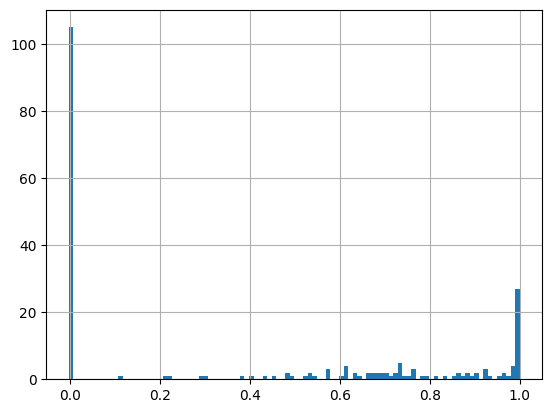

In [146]:
wallace_asvs_cols_filtered_corr.hist(bins=100)

### Analysis with the OTUs table

In [190]:
otu_table_taxonomy_df = pd.read_table('/media/rsantos/4TB_drive/Projects/UGA_RACS/16S/Workflow/2_QiimeOtus/2f_otu_table.sample_filtered.no_mitochondria_chloroplast_taxonomy.tsv',
                                      comment='#')

otu_table_taxonomy_df.set_index('OTU ID', inplace=True)
otu_table_taxonomy_df.drop('taxonomy', axis=1, inplace=True)
otu_table_taxonomy_df.head()

/tmp/ipykernel_353508/4037278442.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  otu_table_taxonomy_df = pd.read_table('/media/rsantos/4TB_drive/Projects/UGA_RACS/16S/Workflow/2_QiimeOtus/2f_otu_table.sample_filtered.no_mitochondria_chloroplast_taxonomy.tsv',


,LMAN.8.14A0051,LMAN.8.14A0304,LMAD.8.14A0247,LMAN.8.14A0159,LMAD.8.14A0051,LMAD.26.14A0381,LMAD.26.14A0533,LMAD.8.14A0281,LMAD.8.14A0295,LMAN.26.14A0319,...,LMAN.26.14A0303,LMAN.8.14A0011,LMAD.26.14A0137,LMAN.26.14A0327,LMAN.8.14A0205,LMAD.8.14A0265,LMAD.26.14A0155,LMAD.26.14A0167,LMAD.26.14A0481,LMAN.26.14A0329
OTU ID,,,,,,,,,,,,,,,,,,,,,
4479944,1.0,2.0,1.0,1.0,1.0,3.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
995900,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,8.0,15.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1124709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
541139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
533625,1.0,36.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [191]:
otu_genotype_day_day_dict = {}
otu_genotype_day_night_dict = {}

sample_dict = {}

for sample in otu_table_taxonomy_df.columns:
    plot = sample.split('.')[2]
    day = str(sample.split('.')[1])
    day_period = sample.split('.')[0].replace('LMA', '')
    #print(plot, day, day_period)
    if plot+"_"+day in sample_dict.keys():
        sample_dict[plot+"_"+day]+=1
    else:
        sample_dict[plot+"_"+day]=1
    if day_period == 'D':
        otu_genotype_day_day_dict[sample] = plot+"_"+day
    elif day_period == 'N':
        otu_genotype_day_night_dict[sample] = plot+"_"+day
    else:
        print('Error: ', sample)
        exit(1)

day_night_samples = []

for key in sample_dict.keys():
    if sample_dict[key] == 2:
        day_night_samples.append(key)

print(f'There are {len(day_night_samples)} cases that day and night samples are available.')

#for sample_d_n in day_night_samples:
#    print(f'{sample_d_n}')


There are 249 cases that day and night samples are available.


In [192]:
otu_genotype_day_night_dict.keys()

dict_keys(['LMAN.8.14A0051', 'LMAN.8.14A0304', 'LMAN.8.14A0159', 'LMAN.26.14A0319', 'LMAN.26.14A0341', 'LMAN.8.14A0119', 'LMAN.8.14A0135', 'LMAN.26.14A0465', 'LMAN.8.14A0343', 'LMAN.26.14A0169', 'LMAN.8.14A0263', 'LMAN.8.14A0117', 'LMAN.8.14A0225', 'LMAN.26.14A0431', 'LMAN.26.14A0471', 'LMAN.26.14A0499', 'LMAN.26.14A0349', 'LMAN.26.14A0521', 'LMAN.8.14A0576', 'LMAN.26.14A0415', 'LMAN.26.14A0539', 'LMAN.8.14A0191', 'LMAN.8.14A0287', 'LMAN.8.14A0303', 'LMAN.8.14A0305', 'LMAN.26.14A0315', 'LMAN.26.14A0351', 'LMAN.26.14A0353', 'LMAN.26.14A0421', 'LMAN.26.14A0447', 'LMAN.26.14A0453', 'LMAN.26.14A0461', 'LMAN.26.14A0469', 'LMAN.26.14A0475', 'LMAN.26.14A0485', 'LMAN.26.14A0491', 'LMAN.26.14A0501', 'LMAN.26.14A0505', 'LMAN.26.14A0507', 'LMAN.26.14A0523', 'LMAN.8.14A0031', 'LMAN.8.14A0233', 'LMAN.26.14A0309', 'LMAN.26.14A0477', 'LMAN.26.14A0497', 'LMAN.26.14A0519', 'LMAN.26.14A0566', 'LMAN.26.14A0569', 'LMAN.8.14A0059', 'LMAN.26.14A0293', 'LMAN.26.14A0511', 'LMAN.8.14A0023', 'LMAN.8.14A0187', '

#### Separating day from night samples into two different matrices

In [193]:
otu_table_day_cols = otu_table_taxonomy_df.loc[:, list(otu_genotype_day_day_dict.keys())]
otu_table_night_cols = otu_table_taxonomy_df.loc[:, list(otu_genotype_day_night_dict.keys())]

In [194]:
otu_table_day_cols.head()

,LMAD.8.14A0247,LMAD.8.14A0051,LMAD.26.14A0381,LMAD.26.14A0533,LMAD.8.14A0281,LMAD.8.14A0295,LMAD.26.14A0169,LMAD.8.14A0069,LMAD.26.14A0497,LMAD.8.14A0023,...,LMAD.8.14A0345,LMAD.8.14A0267,LMAD.8.14A0009,LMAD.8.14A0007,LMAD.26.14A0093,LMAD.26.14A0137,LMAD.8.14A0265,LMAD.26.14A0155,LMAD.26.14A0167,LMAD.26.14A0481
OTU ID,,,,,,,,,,,,,,,,,,,,,
4479944,1.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
995900,0.0,0.0,0.0,0.0,5.0,8.0,5.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1124709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
541139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
533625,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Renaming the columns from runs to "day_plot"

In [195]:
otu_table_day_cols = otu_table_day_cols.rename(columns=otu_genotype_day_day_dict)
otu_table_night_cols = otu_table_night_cols.rename(columns=otu_genotype_day_night_dict)

In [197]:
otu_table_day_cols.head()

,14A0247_8,14A0051_8,14A0381_26,14A0533_26,14A0281_8,14A0295_8,14A0169_26,14A0069_8,14A0497_26,14A0023_8,...,14A0345_8,14A0267_8,14A0009_8,14A0007_8,14A0093_26,14A0137_26,14A0265_8,14A0155_26,14A0167_26,14A0481_26
OTU ID,,,,,,,,,,,,,,,,,,,,,
4479944,1.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
995900,0.0,0.0,0.0,0.0,5.0,8.0,5.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1124709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
541139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
533625,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [196]:
otu_table_night_cols.head()

,14A0051_8,14A0304_8,14A0159_8,14A0319_26,14A0341_26,14A0119_8,14A0135_8,14A0465_26,14A0343_8,14A0169_26,...,14A0197_8,14A0247_8,14A0211_26,14A0339_8,14A0093_26,14A0303_26,14A0011_8,14A0327_26,14A0205_8,14A0329_26
OTU ID,,,,,,,,,,,,,,,,,,,,,
4479944,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
995900,0.0,1.0,0.0,15.0,2.0,5.0,3.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1124709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
541139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
533625,1.0,36.0,0.0,12.0,2.0,56.0,0.0,42.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



#### Filter columns that are present in day and night period matrices based on "day_plot" association

In [198]:
otu_table_day_cols_filtered = otu_table_day_cols.filter(items=otu_table_night_cols.columns)
otu_table_night_cols_filtered = otu_table_night_cols.filter(items=otu_table_day_cols.columns)

In [199]:
print(otu_table_day_cols.shape)
print(otu_table_night_cols.shape)

print(otu_table_day_cols_filtered.shape)
print(otu_table_night_cols_filtered.shape)

(9057, 260)
(9057, 280)
(9057, 249)
(9057, 249)


In [200]:
otu_table_day_cols_filtered = otu_table_day_cols_filtered.reindex(columns=otu_table_night_cols_filtered.columns)

In [201]:
if otu_table_day_cols_filtered.columns.all == otu_table_night_cols_filtered.columns.all:
    print('Columns are equal!')

Columns are equal!


In [202]:
if list(otu_table_day_cols_filtered.index) == list(otu_table_night_cols_filtered.index):
    print('Indices are equal!')

Indices are equal!


In [203]:
otu_table_cols_filtered_corr = otu_table_day_cols_filtered.corrwith(otu_table_night_cols_filtered, axis = 0)

<Axes: >

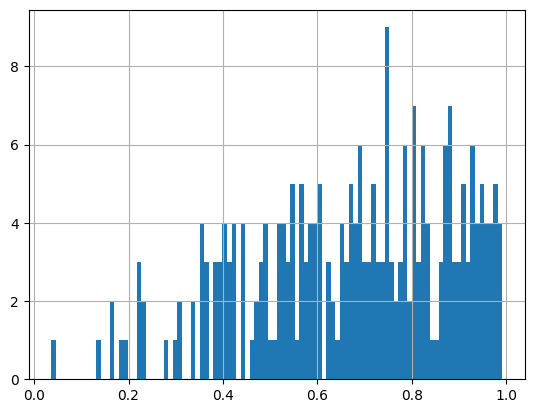

In [204]:
otu_table_cols_filtered_corr.hist(bins=100)